説明変数が腫瘤の特徴量の平均，目的変数が診断結果である二項ロジスティック回帰モデルを作成

$\mu=\alpha+\beta X$ \\
$\theta=\operatorname{logistic}(\mu)$ \\
$y \sim \operatorname{Bern}(\theta)$


https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

また、被験者ごとの癌の特徴に加え，被験者の個人差を考慮した階層ベイズモデルを作成し、両者の予測精度を比較する

In [ ]:
import pystan
import arviz
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
cancer = pd.read_csv('input/breast-cancer-wisconsin-data.csv')
cancer=cancer.replace({'diagnosis': {'M': 1}})
cancer=cancer.replace({'diagnosis': {'B': 0}})
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [ ]:
y = cancer.iloc[:, 1] # 目的変数として診断結果
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [ ]:
x = cancer.iloc[:, [2,3,4,5,6,7,8,9,10,11]] # 説明変数として腫瘤の特徴量
x1 = cancer['radius_mean']
x2 = cancer['texture_mean']
x3 = cancer['area_mean']

In [ ]:
stan_data = {
    'N': x.shape[0], # データ数
    'x1': x1,
    'x2': x2, 
    'x3': x3,
    'y': y
    }
stan_data

{'N': 569, 'x1': 0      17.99
 1      20.57
 2      19.69
 3      11.42
 4      20.29
        ...  
 564    21.56
 565    20.13
 566    16.60
 567    20.60
 568     7.76
 Name: radius_mean, Length: 569, dtype: float64, 'x2': 0      10.38
 1      17.77
 2      21.25
 3      20.38
 4      14.34
        ...  
 564    22.39
 565    28.25
 566    28.08
 567    29.33
 568    24.54
 Name: texture_mean, Length: 569, dtype: float64, 'x3': 0      1001.0
 1      1326.0
 2      1203.0
 3       386.1
 4      1297.0
         ...  
 564    1479.0
 565    1261.0
 566     858.1
 567    1265.0
 568     181.0
 Name: area_mean, Length: 569, dtype: float64, 'y': 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 564    1
 565    1
 566    1
 567    1
 568    0
 Name: diagnosis, Length: 569, dtype: int64}

階層なしモデル

In [ ]:
stan_code = """
data {
  int N; // データ数
  real x1[N];
  real x2[N];
  real x3[N];
  int<lower=0, upper=1> y[N]; // 目的変数
}

parameters {
  real a; // 切片
  real b1;
  real b2;
  real b3;
}
transformed parameters {
    real p[N];
    for (i in 1:N){
        p[i] =a+b1*x1[i] + b2*x2[i] + b3*x3[i];
    }

}
model {
  for (i in 1:N) {
    y[i] ~ bernoulli_logit(p[i]);
  }
}
"""

In [ ]:
model = pystan.StanModel(model_code=stan_code) 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_db2d417d71ce7414f84bb59a3e3ff56f NOW.


In [ ]:
# MCMCの実行
fit = model.sampling(
    data = stan_data, 
    iter = 2000, 
    warmup = 1000, 
    chains = 4, 
    thin = 1, 
    seed = 1 
)

階層ありモデル

In [ ]:
stan_code = """
data {
  int N; // データ数
  real x1[N];
  real x2[N];
  real x3[N];
  int<lower=0, upper=1> y[N]; // 目的変数
}

parameters {
  real a; // 切片
  real b1;
  real b2;
  real b3;
  real bs[N];
  real<lower=0> sigma_s; // 被験者ごとのばらつき
}
transformed parameters {
    real p[N];
    for (i in 1:N){
        p[i] =a+b1*x1[i] + b2*x2[i] + b3*x3[i]+bs[i];
    }

}
model {
  for (s in 1:N) {
        bs[s] ~ normal(0, sigma_s);
    }
  for (i in 1:N) {
    y[i] ~ bernoulli_logit(p[i]);
  }
}
"""

In [ ]:
hierarchial_model = pystan.StanModel(model_code=stan_code) 

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7fdecebfb1d7ace29d421d9189b731f NOW.


In [ ]:
# MCMCの実行
fit2 = hierarchial_model.sampling(
    data = stan_data, 
    iter = 2000, 
    warmup = 1000, 
    chains = 4, 
    thin = 1, 
    seed = 1
)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_db2d417d71ce7414f84bb59a3e3ff56f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd    2.5%    25%     50%    75%  97.5%  n_eff   Rhat
a       -9.72    0.21   6.46  -22.62 -14.22   -9.44  -5.39   2.31    918    1.0
b1      -0.39    0.03    0.9   -2.12  -0.99   -0.41   0.23   1.38    924    1.0
b2       0.21  1.1e-3   0.04    0.14   0.19    0.21   0.24   0.29   1231    1.0
b3       0.02  3.4e-4   0.01 -3.5e-3 9.6e-3    0.02   0.02   0.04    932    1.0
p[1]     2.22    0.02   0.71    0.94   1.72    2.19   2.69   3.72   1235    1.0
p[2]     8.23    0.05   1.69    5.18   7.05    8.16   9.36  11.78   1114    1.0
p[3]     7.25    0.03   1.21     5.1   6.38    7.19   8.04   9.84   1248    1.0
p[4]    -3.39  5.3e-3    0.3    -4.0  -3.58   -3.38  -3.18  -2.82   3141    1.0
p[5]     7.12    0.05   1.64    4.16   5.97    7.04   8.22  10.59   1089    1.0
p[6]    -3.

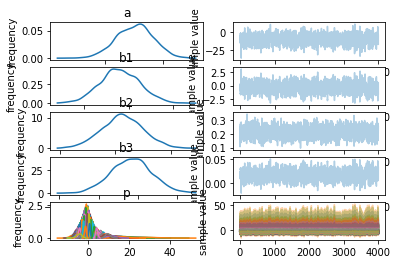

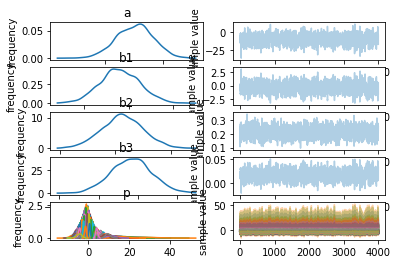

In [ ]:
print (fit)
fit.plot()

Inference for Stan model: anon_model_b7fdecebfb1d7ace29d421d9189b731f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd    2.5%    25%     50%     75%   97.5%  n_eff   Rhat
a       -300.1   110.9  323.1   -1135 -473.6  -207.1  -38.41   54.74      8   1.49
b1      -13.87    4.14  30.31  -81.94 -28.47   -7.57    0.46   45.51     54   1.07
b2        6.98    2.76   5.46    0.28   1.77    6.09   10.63   19.65      4   2.36
b3        0.54    0.21    0.5 -6.4e-3   0.13     0.4    0.87    1.62      6   1.46
bs[1]    17.82    6.21  60.33  -93.85 -11.11    3.84   42.25  171.69     94   1.03
bs[2]     0.37    5.46  68.83  -150.9 -26.31    0.22   25.05  160.09    159   1.02
bs[3]     6.37    5.64  70.46  -151.1 -18.23    0.65    32.9  163.65    156   1.01
bs[4]   128.43   52.13  97.36    1.95  35.94  119.73  196.12   335.4      3    2.5
bs[5]     8.92    5.67  67.94  -124.8 -18.01     1.4    30.9  16

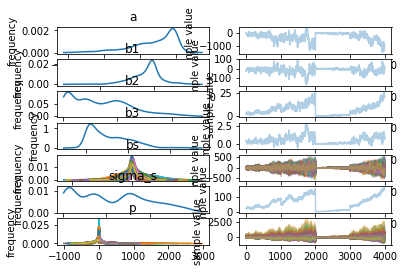

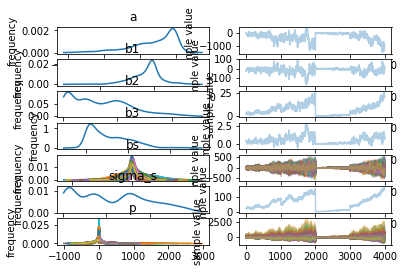

In [ ]:
print (fit2)
fit.plot()

In [ ]:
names = fit.model_pars
print (names)

['a', 'b1', 'b2', 'b3', 'p']


In [ ]:
names2 = fit2.model_pars
print (names2)

['a', 'b1', 'b2', 'b3', 'bs', 'sigma_s', 'p']


In [ ]:
a, bb1, bb2, bb3 = np.mean(fit['a']), np.mean(fit['b1']), np.mean(fit['b2']), np.mean(fit['b3'])
print (a, bb1, bb2, bb3)

-9.71792497445131 -0.3923065793911643 0.21287736752184705 0.016767749868212393


In [ ]:
a, bb1, bb2, bb3 = np.mean(fit2['a']), np.mean(fit2['b1']), np.mean(fit2['b2']), np.mean(fit2['b3'])
print (a, bb1, bb2, bb3)

sigma_s= np.mean(fit2['sigma_s'])
print (sigma_s)

-300.1183880852818 -13.86613985567166 6.982324697758309 0.5422351697443724
57.480933070000006


INFO:numexpr.utils:NumExpr defaulting to 2 threads.


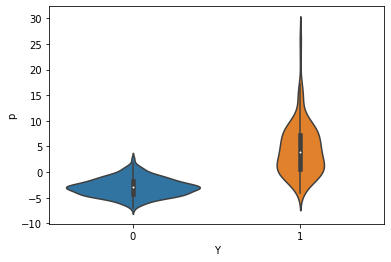

In [ ]:
p = fit['p'].T
p_median = []
for i in range(len(y)):
    p_median.append(np.median(p[i]))

plot_df = pd.DataFrame({
    'Y': y,
    'p': p_median
})
sns.violinplot(x='Y', y='p', data=plot_df)
plt.show()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


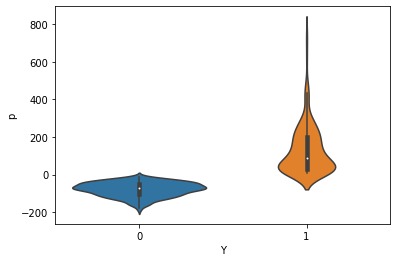

In [ ]:
p = fit2['p'].T
p_median = []
for i in range(len(y)):
    p_median.append(np.median(p[i]))

plot_df = pd.DataFrame({
    'Y': y,
    'p': p_median
})
sns.violinplot(x='Y', y='p', data=plot_df)
plt.show()